In this Homework, you will make a Bi-directional translation model (i.e. it should do english to arabic as well as arabic to english translation) using T5-small arhcitecture. You will use Huggingface transformers library for this.

TODO:
1. Create a combined tokenization model for English and arabic using [sentencepiece](https://github.com/google/sentencepiece/blob/master/python/README.md). Don't forget to add pad_id, unk_id, bos_id, eos_id. Choose an appropriate vocabulary size.
2. Split the data into 90:10 train and test set. Make it compaitble to be used by huggingface transformers trainer and for bi-directional training.
3. Load the sentencepiece tokenizer into T5 tokenizer in huggingface. Study how you can do this.
4. Load an untrained T5 small model from hugging face transformers. You will need to specify your own vocab size for embedding layer. You can also make more changes if you want.
5. Train this model on your training data using huggingface transformers trainer. As you will be training it both way you can use a task descriptors like "Translate from english to arabic: ..." and "Translate from arabic to English: ..." before your input sentence.
6. Evaluate your models on test data and calculate the [bleu score](https://huggingface.co/spaces/evaluate-metric/bleu). You can use the evalute model as specified in the link.
7. Show some example inpu, true translation and generated translation from the test data. Do this for both english to arabic and arabic to english.



If the below code to download data doesn't work due to usage restrictions, download it directly from [here](https://drive.google.com/file/d/1APYsNu_geYk8d9vkI1e3EkLSTi4YPWDq/view?usp=sharing) and upload it your runtime.

In [1]:
!gdown "1APYsNu_geYk8d9vkI1e3EkLSTi4YPWDq"

Downloading...
From: https://drive.google.com/uc?id=1APYsNu_geYk8d9vkI1e3EkLSTi4YPWDq
To: /content/arabic_english.txt
100% 6.50M/6.50M [00:00<00:00, 40.5MB/s]


In [2]:
from IPython.display import clear_output, display
%pip install datasets
%pip install transformers[torch]  # [torch] because Trainer API with torch needs accelerator installed. This takes care of that. Might need a restart of the session
%pip install gdown==4.5
%pip install evaluate
%pip install rouge_score
# %pip install pyarrow==16.0.0
clear_output()


In [3]:
from IPython.display import clear_output, display
import os
import math
import random
import torch

from datasets import load_dataset, Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config, GenerationConfig, TrainingArguments, Trainer, TrainerCallback
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
# from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import CocoCaptions
import matplotlib.pyplot as plt
from tqdm import tqdm
import sentencepiece
import csv
from sklearn.model_selection import train_test_split
import pandas as pd
clear_output()


## 1- tokenization
Create a combined tokenization model for English and arabic using [sentencepiece](https://github.com/google/sentencepiece/blob/master/python/README.md). Don't forget to add pad_id, unk_id, bos_id, eos_id. Choose an appropriate vocabulary size.



In [4]:
sentencepiece.SentencePieceTrainer.train(
  input="arabic_english.txt",
  model_prefix="myspm_model",
  vocab_size=10000,
  pad_id=0,
  unk_id=3,
  bos_id=2,
  eos_id=1,
  pad_piece='<pad>',
  unk_piece='<unk>',
  bos_piece='<sos>',
  eos_piece='</s>'
)

In [5]:
spm = sentencepiece.SentencePieceProcessor(model_file="myspm_model.model")
vocab = [spm.id_to_piece(i) for i in range(spm.get_piece_size())]
print("Vocabulary sample:")
print(vocab[10:20])

Vocabulary sample:
['▁في', '▁to', '▁من', '▁of', '▁a', '▁in', '▁and', 'ed', '▁على', '▁و']


In [6]:
english_sentences = []
arabic_sentences = []

with open("arabic_english.txt", 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        # english_sentence = spm.encode_as_ids(row[0])
        # arabic_sentence = spm.encode_as_ids(row[1])
        # english_sentence = [spm.bos_id()] + english_sentence + [spm.eos_id()]
        # arabic_sentence = [spm.bos_id()] + arabic_sentence + [spm.eos_id()]
        english_sentences.append(row[0])
        arabic_sentences.append(row[1])

print(english_sentences[0])
print(arabic_sentences[0])
# print(spm.decode(english_sentences[0]))
# print(spm.decode(arabic_sentences[0]))

Hi.
مرحبًا.


## 2-Splitting Data
2. Split the data into 90:10 train and test set. Make it compaitble to be used by huggingface transformers trainer and for bi-directional training.

In [7]:
# Split the data into 90:10 train and test set. Make it compaitble to be used by huggingface transformers trainer and for bi-directional training.
df = pd.DataFrame({'english': english_sentences, 'arabic': arabic_sentences})
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)


In [8]:
print(train_df.iloc[0])
print(test_df.iloc[0])

print("shape of train data is", train_df.shape)
print("shape of test data is", test_df.shape)

english    updates on how crowdfunding efforts are coming...
arabic     تحديثات تتحدث عن جهودهم القادمة واطلاقاتهم وحل...
Name: 14108, dtype: object
english    along the way she lost a shoe.
arabic            وعلى الطريق فقدت حذاءها
Name: 22818, dtype: object
shape of train data is (22174, 2)
shape of test data is (2464, 2)


In [9]:
train_dataset = Dataset.from_pandas(train_df, split='train')
test_dataset = Dataset.from_pandas(test_df, split='test')

## 3-Loading the sentencepiece tokenizer into T5 tokenizer
3. Load the sentencepiece tokenizer into T5 tokenizer in huggingface. Study how you can do this.

In [10]:
tokenizer = T5Tokenizer(vocab_file='myspm_model.model')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [11]:
sample_sentence = "This is a test sentence."
sample_sentence2 = "هذه جمله"

encoded_sentence = tokenizer.encode(sample_sentence)
encoded_sentence_by_spm = spm.encode_as_ids(sample_sentence)
encoded_sentence2 = tokenizer.encode(sample_sentence2)
print("Encoded sentence:", encoded_sentence)
print("Encoded sentence by spm:", encoded_sentence_by_spm)
print("Encoded sentence:", encoded_sentence2)

decoded_sentence = tokenizer.decode(encoded_sentence)
decoded_sentence2 = tokenizer.decode(encoded_sentence2)
print("Decoded sentence:", decoded_sentence)
print("Decoded sentence:", decoded_sentence2)

Encoded sentence: [628, 7, 24, 14, 2716, 1370, 5, 1]
Encoded sentence by spm: [628, 7, 24, 14, 2716, 1370, 5]
Encoded sentence: [96, 4, 4522, 25, 1]
Decoded sentence: This is a test sentence.</s>
Decoded sentence: هذه جمله</s>


In [12]:
def tokenize_function(examples):
    src_language = 'english'
    tgt_language = 'arabic'

    # Randomly switch source and target languages
    if random.randint(0, 1) == 1:
        src_language, tgt_language = tgt_language, src_language

    # src_tokenizer, tgt_tokenizer = [tokenizer(language) for language in (src_language, tgt_language)]

    start_prompt = f'Translate from {src_language} to {tgt_language}: '
    end_prompt = ''

    # Create prompts and tokenize
    prompts = [start_prompt + row for row in examples[src_language]]
    examples['src_language'] = [src_language] * len(examples[src_language])
    examples['prompt'] = prompts

    encoding = tokenizer(prompts, padding="max_length", truncation=True, return_tensors="pt", max_length=256)
    examples['input_ids'] = encoding['input_ids']
    examples['attention_mask'] = encoding['attention_mask']
    examples['labels'] = tokenizer(examples[tgt_language], padding="max_length", truncation=True, return_tensors="pt", max_length=256)['input_ids']

    return examples
# Tokenize the datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True).shuffle(seed=13)
tokenized_test = test_dataset.map(tokenize_function, batched=True).shuffle(seed=13)

# Print a sample to verify
print(tokenized_train[0])
print(tokenized_test[0])

Map:   0%|          | 0/22174 [00:00<?, ? examples/s]

Map:   0%|          | 0/2464 [00:00<?, ? examples/s]

{'english': "She'll be getting married next year.", 'arabic': 'إنها ستتزوج العام المقبل.', '__index_level_0__': 8818, 'src_language': 'english', 'prompt': "Translate from english to arabic: She'll be getting married next year.", 'input_ids': [1216, 2859, 7, 346, 414, 62, 1138, 11, 1328, 3, 315, 43, 195, 77, 4, 1958, 5793, 1044, 267, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
english, arabic = False, False
for sample in tokenized_train:
  if (sample.get('src_language') == 'arabic') and not arabic:
    arabic = True
    print("arabic as a source: ", sample.get('src_language'))
  elif (sample.get('src_language') == 'english') and not english:
    english = True
    print("english as a source: ", sample.get('src_language'))
  if (english and arabic):
    break


english as a source:  english
arabic as a source:  arabic


## 4-Load an untrained T5 small model
4. Load an untrained T5 small model from hugging face transformers. You will need to specify your own vocab size for embedding layer. You can also make more changes if you want.

In [17]:
t5_small_config = T5Config(
    vocab_size=10000,
    d_model=512,
    d_kv=64,
    d_ff=2048,
    num_layers=6,
    num_heads=8,
    relative_attention_num_buckets=32,
    dropout_rate=0.1,
    layer_norm_epsilon=1e-6,
    initializer_factor=1.0,
    feed_forward_proj="relu",
    is_encoder_decoder=True,
    use_cache=True,
    pad_token_id=0,
    eos_token_id=1,
    bos_token_id=2,
    unk_token_id=3,
    forced_eos_token_id=1,
    decoder_start_token_id=2
)

# Initialize the model with the config
model = T5ForConditionalGeneration(t5_small_config)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
sample_arabic = 'الطقس جميل'
# print(tokenizer(sample_arabic, return_tensors='pt'))
with torch.no_grad():
    res = model.generate(**tokenizer(sample_arabic, return_tensors='pt').to(device))
tokenizer.batch_decode(res)[0]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'</s>'

## 5-Training the model
5. Train this model on your training data using huggingface transformers trainer. As you will be training it both way you can use a task descriptors like "Translate from english to arabic: ..." and "Translate from arabic to English: ..." before your input sentence.

In [19]:
train_losses = []
val_losses = []

class CustomCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                train_losses.append(logs["loss"])
            if "eval_loss" in logs:
                val_losses.append(logs["eval_loss"])

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_strategy="steps",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    callbacks=[CustomCallback()]
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
500,0.748500,0.736077
1000,0.756900,0.705865
1500,0.728700,0.683579
2000,0.678000,0.669604
2500,0.639500,0.656332
3000,0.621000,0.647533
3500,0.660200,0.638060
4000,0.642900,0.630565
4500,0.598700,0.624880
5000,0.639600,0.620349


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-defau

Step,Training Loss,Validation Loss
500,0.748500,0.736077
1000,0.756900,0.705865
1500,0.728700,0.683579
2000,0.678000,0.669604
2500,0.639500,0.656332
3000,0.621000,0.647533
3500,0.660200,0.638060
4000,0.642900,0.630565
4500,0.598700,0.624880
5000,0.639600,0.620349


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-defau

TrainOutput(global_step=27720, training_loss=0.5602026758427916, metrics={'train_runtime': 15638.3772, 'train_samples_per_second': 28.358, 'train_steps_per_second': 1.773, 'total_flos': 3.001069105840128e+16, 'train_loss': 0.5602026758427916, 'epoch': 20.0})

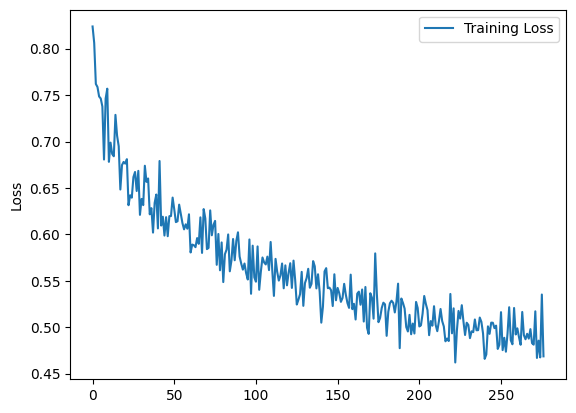

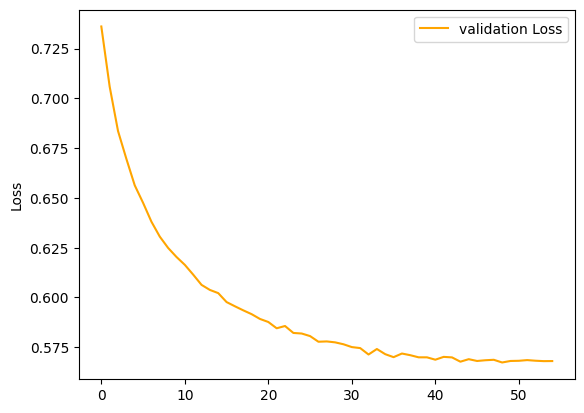

In [27]:
plt.plot(train_losses, label='Training Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(val_losses, label='validation Loss', color="orange")
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
model.save_pretrained('t5_translation_weights')
tokenizer.save_pretrained('t5_translation_weights')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 1}


('t5_translation_weights/tokenizer_config.json',
 't5_translation_weights/special_tokens_map.json',
 't5_translation_weights/spiece.model',
 't5_translation_weights/added_tokens.json')

## 6-Model Evaluation (BLEU score)
6. Evaluate your models on test data and calculate the [bleu score](https://huggingface.co/spaces/evaluate-metric/bleu). You can use the evalute model as specified in the link.

In [22]:
import evaluate
bleu = evaluate.load("bleu")

In [23]:
def generate_translation(prompt):
    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    with torch.no_grad():
        output_ids = model.generate(**inputs)
    translated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return translated_text


print(tokenized_test[0]['prompt'])


arabic_references = []
arabic_predictions = []
english_references = []
english_predictions = []


for record in tokenized_test:
    prompt = record['prompt']
    src_language = record['src_language']
    tgt_language = 'arabic' if src_language == 'english' else 'english'
    true_translation = record[tgt_language]

    generated_translation = generate_translation(prompt)

    if src_language == 'english':
        english_references.append([true_translation])
        english_predictions.append(generated_translation)
    else:
        arabic_references.append([true_translation])
        arabic_predictions.append(generated_translation)
    # print(f"True {tgt_language.capitalize()}: {true_translation}")
    # print(f"Generated {tgt_language.capitalize()}: {generated_translation}")
    # print()
    # break

# Compute BLEU score
arabic_bleu_score = bleu.compute(predictions=arabic_predictions, references=arabic_references)
english_bleu_score = bleu.compute(predictions=english_predictions, references=english_references)
print(f"\n {'==' * 10} arabic BLEU score: {arabic_bleu_score} {'==' * 10}")
print(f"\n {'==' * 10} english BLEU score: {english_bleu_score} {'==' * 10}")

Translate from arabic to english: وقد وصفها احد المسيولين بانها اعتى عاصفة منذ عاما بالانجليزية حيث تم اجلاء الالاف الى غرف الطواري والمستشفيات


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(



 ==================== arabic BLEU score: {'bleu': 0.011385724366902652, 'precisions': [0.2856573705179283, 0.05143805309734513, 0.014179104477611941, 0.002980414419528811], 'brevity_penalty': 0.4055989407600095, 'length_ratio': 0.5256544502617801, 'translation_length': 10040, 'reference_length': 19100} ====================

 ==================== english BLEU score: {'bleu': 0.0069894185304261724, 'precisions': [0.2054766734279919, 0.03273419830972503, 0.008768147189880695, 0.005897069335239456], 'brevity_penalty': 0.287815362901247, 'length_ratio': 0.44534778681120146, 'translation_length': 9860, 'reference_length': 22140} ====================


## 7-Real Examples
7. Show some example inpu, true translation and generated translation from the test data. Do this for both english to arabic and arabic to english.

In [24]:
def display_examples(test_data, num_examples=5):
    for i in range(num_examples):
        record = test_data[i]
        prompt = record['prompt']
        src_language = record['src_language']
        tgt_language = 'arabic' if src_language == 'english' else 'english'
        true_translation = record[tgt_language]

        generated_translation = generate_translation(prompt)

        print(f"Example {i+1}:")
        print(f"Prompt: {prompt}")
        print(f"True {tgt_language.capitalize()}: {true_translation}")
        print(f"Generated {tgt_language.capitalize()}: {generated_translation}")
        print()
        print("-" * 50)

display_examples(tokenized_test)


Example 1:
Prompt: Translate from arabic to english: وقد وصفها احد المسيولين بانها اعتى عاصفة منذ عاما بالانجليزية حيث تم اجلاء الالاف الى غرف الطواري والمستشفيات
True English: one local official called it the heaviest snowfall in years thousands have been rescued and taken to emergency shelters or hospitalized.
Generated English: the y cass of the known as the country such as a

--------------------------------------------------
Example 2:
Prompt: Translate from arabic to english: فيديو يوم من دون سيارات في كنمنغ
True English: video no car day in kunming.
Generated English: a video from the first first time of the first time in the taken by the first

--------------------------------------------------
Example 3:
Prompt: Translate from arabic to english: يظهر ان مستخدمي الانترنت الذين شاهدوا الفيديو قد احبوا طريقته في الغناء علقت فريدة سلمانوفا
True English: netizens reacting to the video apparently like the way nazarbayev sings under the video farida salmenova comments ru.
Generated E